In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Used to color bar charts for each team
color_df = pd.read_csv("Data/team_colors.csv")

In [347]:
# Read in data and add log salary
df_original = pd.read_csv("Data/clean/master_data.csv")
df_original["log salary"] = np.log(df_original["Salary"])

# Include each team hex color for graphing 
df_merged = df_original.merge(color_df, on="Team", how="left")

# Add 
df_merged

,Player,Player-additional,Team,MP,OBPM,DBPM,VORP,Pos,Year,Salary,log salary,hex
0,Precious Achiuwa,achiupr01,MIA,737,-3.6,-0.5,-0.4,PF,2021,2582160.0,14.764137,#98002E
1,Precious Achiuwa,achiupr01,TOR,1725,-2.0,-0.6,-0.2,C,2022,2711280.0,14.812931,#CE1141
2,Precious Achiuwa,achiupr01,TOR,1140,-1.4,-0.8,-0.1,C,2023,2840160.0,14.859371,#CE1141
3,Precious Achiuwa,achiupr01,NYK,1187,-1.9,0.5,0.2,PF,2024,4379527.0,15.292451,#F58426
4,Precious Achiuwa,achiupr01,NYK,1170,-2.1,0.2,0.0,C,2025,6000000.0,15.607270,#F58426
...,...,...,...,...,...,...,...,...,...,...,...,...
2315,Ivica Zubac,zubaciv01,LAC,1609,0.6,0.4,1.2,C,2021,7000000.0,15.761421,#C8102E
2316,Ivica Zubac,zubaciv01,LAC,1852,-0.1,0.8,1.3,C,2022,7518518.0,15.832880,#C8102E
2317,Ivica Zubac,zubaciv01,LAC,2170,-1.1,0.2,0.6,C,2023,10123457.0,16.130366,#C8102E
2318,Ivica Zubac,zubaciv01,LAC,1794,0.8,0.0,1.3,C,2024,10933333.0,16.207327,#C8102E


Text(0.5, 0, 'Salary ($)')

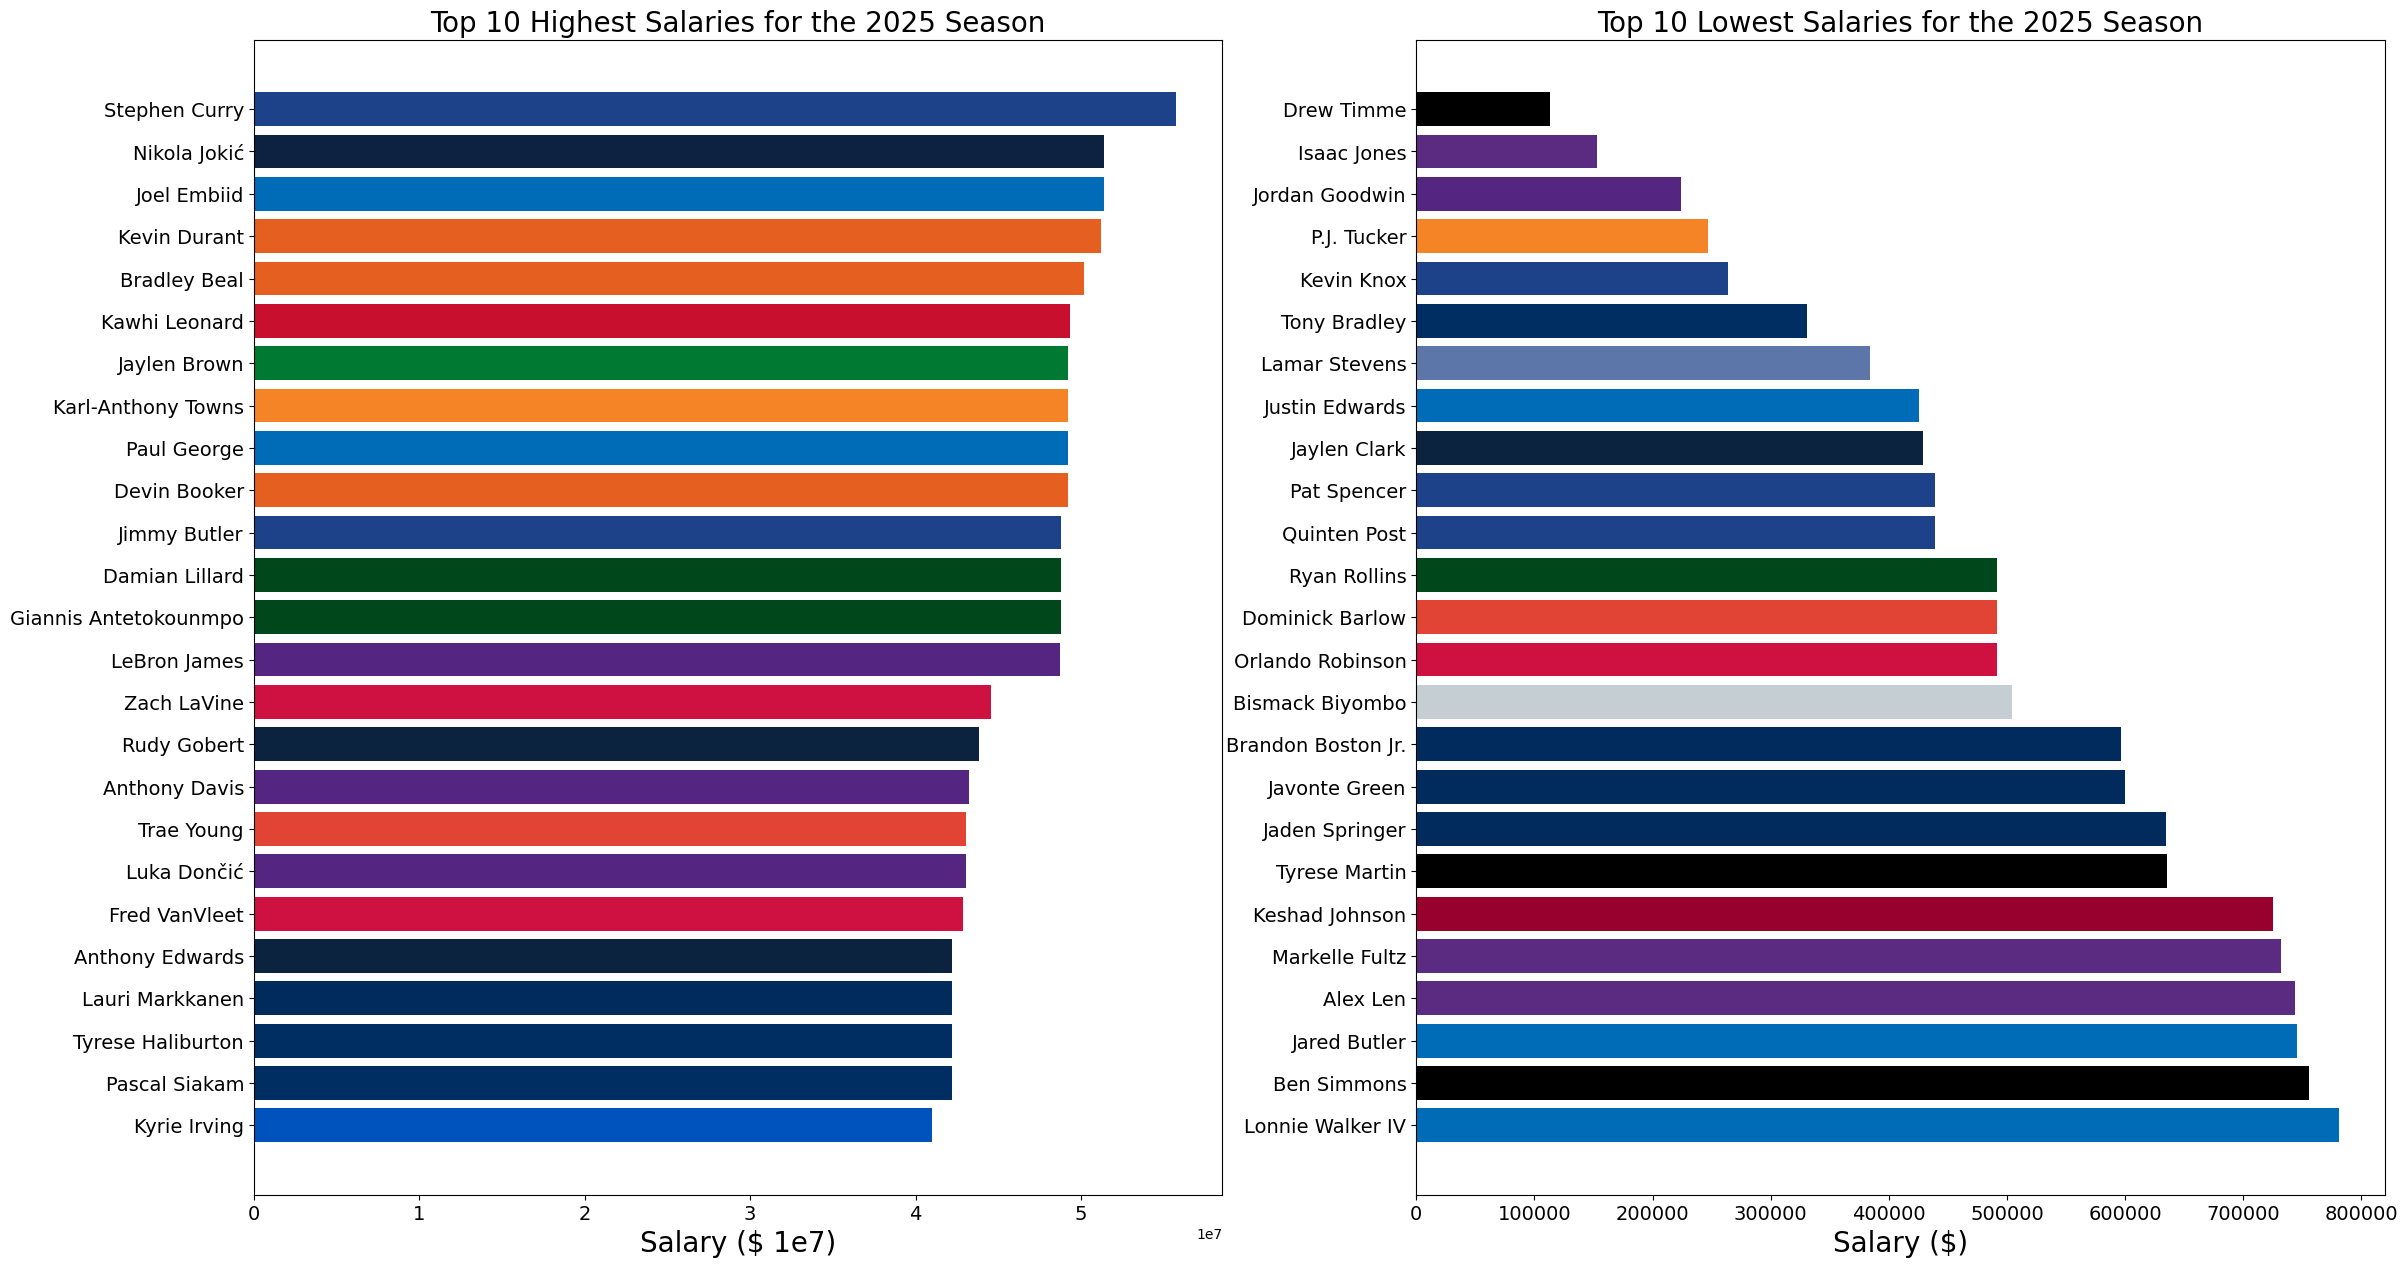

In [348]:
# EDA For 2025
df_2025 = df_merged[df_merged["Year"] == 2025]


highest_paid_10 = df_2025.sort_values("Salary", ascending=False).head(25).sort_values("Salary", ascending=True)
lowest_paid_10 = df_2025.sort_values("Salary", ascending=True).head(25).sort_values("Salary", ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(27.5, 15), sharey=False)

ax[0].barh(highest_paid_10["Player"], highest_paid_10["Salary"], color=highest_paid_10["hex"])
ax[0].set_title("Top 10 Highest Salaries for the 2025 Season", size=20, y=1)
ax[0].tick_params(axis="both", labelsize=14)
ax[0].set
ax[0].set_xlabel("Salary ($ 1e7)", size=20)
ax[1].barh(y=lowest_paid_10["Player"], width = lowest_paid_10["Salary"], color=lowest_paid_10["hex"])
ax[1].set_title("Top 10 Lowest Salaries for the 2025 Season", size=20, y = 1)
ax[1].tick_params(axis="both", labelsize=14)
ax[1].set
ax[1].set_xlabel("Salary ($)", size=20)

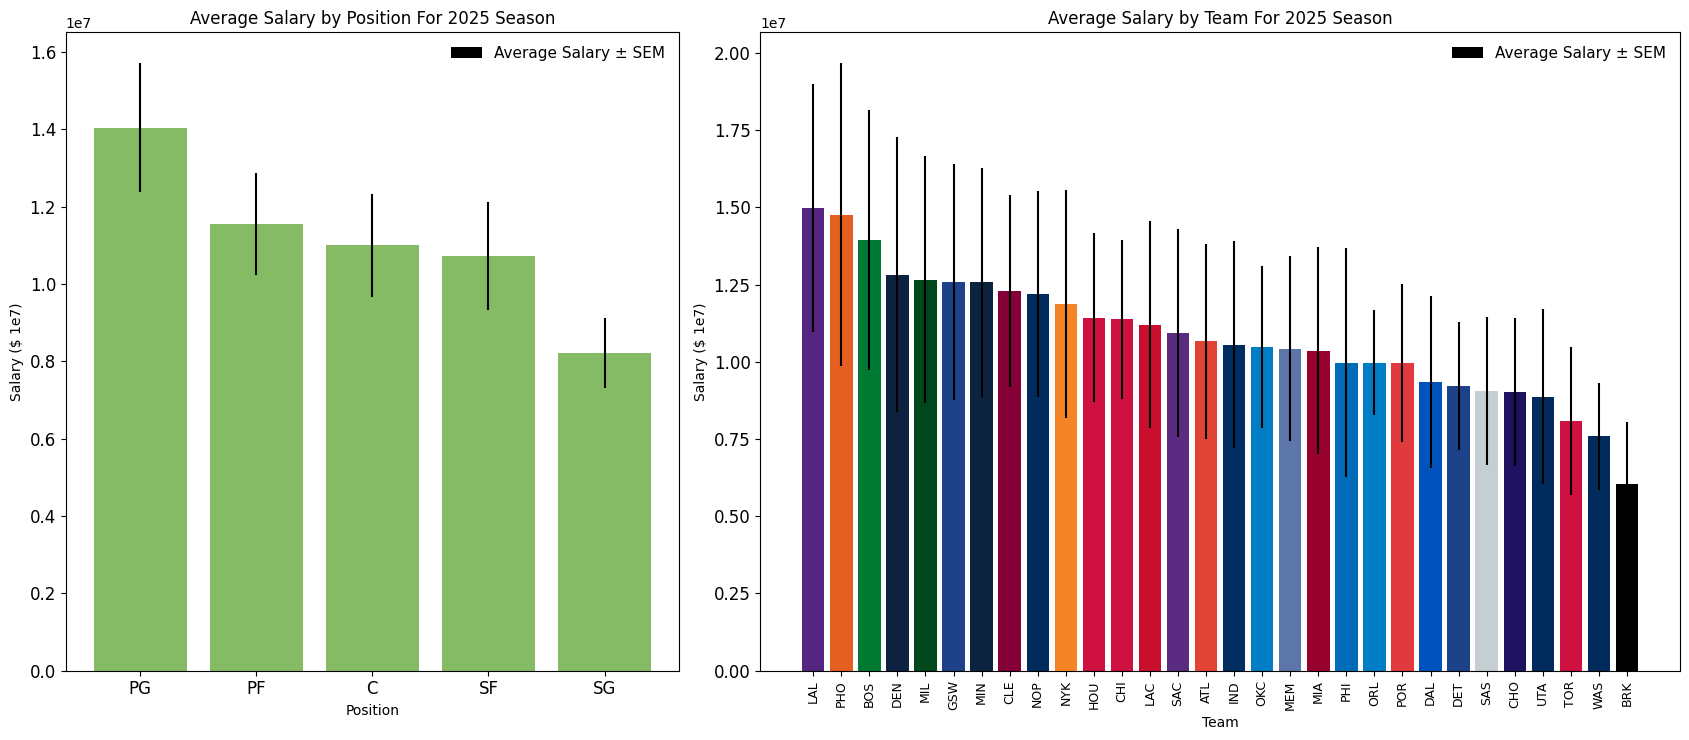

In [349]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Means (sorted)
pos_mean  = df_2025.groupby("Pos")["Salary"].mean().sort_values(ascending=False)
team_mean = df_2025.groupby("Team")["Salary"].mean().sort_values(ascending=False)

# SEM (same order as means)
pos_sem  = df_2025.groupby("Pos")["Salary"].sem().reindex(pos_mean.index)
team_sem = df_2025.groupby("Team")["Salary"].sem().reindex(team_mean.index)

# Build team plot df + merge colors (must happen before plotting)
team_plot = team_mean.reset_index().rename(columns={"Salary": "Salary_mean"})
team_plot["Salary_sem"] = team_sem.values
team_plot = team_plot.merge(color_df, on="Team", how="left")

# Plot
fig, ax = plt.subplots(
    1, 2, figsize=(17, 7.5),
    sharey=False,
    gridspec_kw={"width_ratios": [2, 3]}
)

ax[0].bar(pos_mean.index, pos_mean.values, yerr=pos_sem.values, color="#85BB65")
ax[0].set_xlabel("Position")
ax[0].set_ylabel("Salary ($ 1e7)")
ax[0].set_title("Average Salary by Position For 2025 Season")
ax[0].tick_params(axis="x", labelsize=12)
ax[0].tick_params(axis="y", labelsize=12)

ax[1].bar(team_plot["Team"], team_plot["Salary_mean"], yerr=team_plot["Salary_sem"], color=team_plot["hex"])
ax[1].set_xlabel("Team")
ax[1].set_ylabel("Salary ($ 1e7)")
ax[1].set_title("Average Salary by Team For 2025 Season")
ax[1].tick_params(axis="x", labelrotation=90, labelsize=9)
ax[1].tick_params(axis="y", labelsize=12)

# Legend for positions
legend_handle = Patch(
    facecolor="#000000",
    label="Average Salary ± SEM"
)

ax[0].legend(
    handles=[legend_handle],
    loc="upper right",
    fontsize=11,
    frameon=False
)

ax[1].legend(
    handles=[legend_handle],
    loc="upper right",
    fontsize=11,
    frameon=False
)


plt.tight_layout()
plt.show()


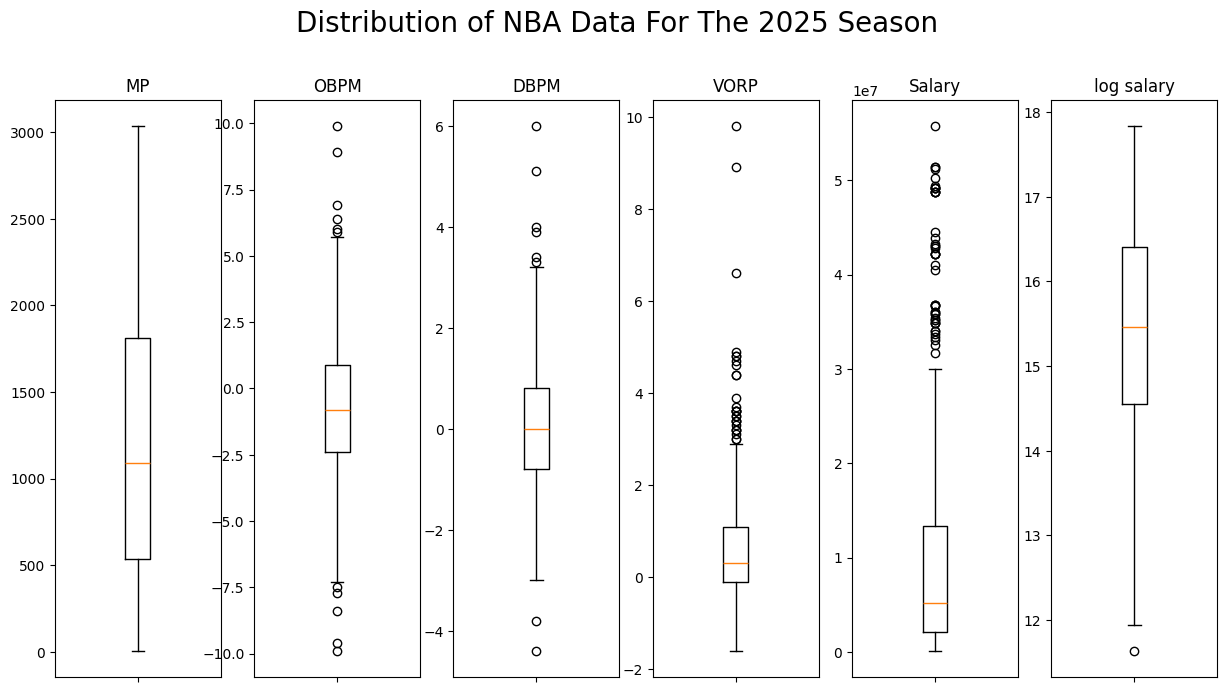

In [350]:
fig, ax = plt.subplots(1, 6, figsize=(15, 7.5), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "Salary","log salary"]

for j, col in enumerate(cols):
    ax[j].boxplot(df_2025[col].dropna())
    ax[j].set_title(col)
    ax[j].tick_params(axis="x", labelbottom=False)

fig.suptitle("Distribution of NBA Data For The 2025 Season", fontsize=20, y=1)
plt.show()


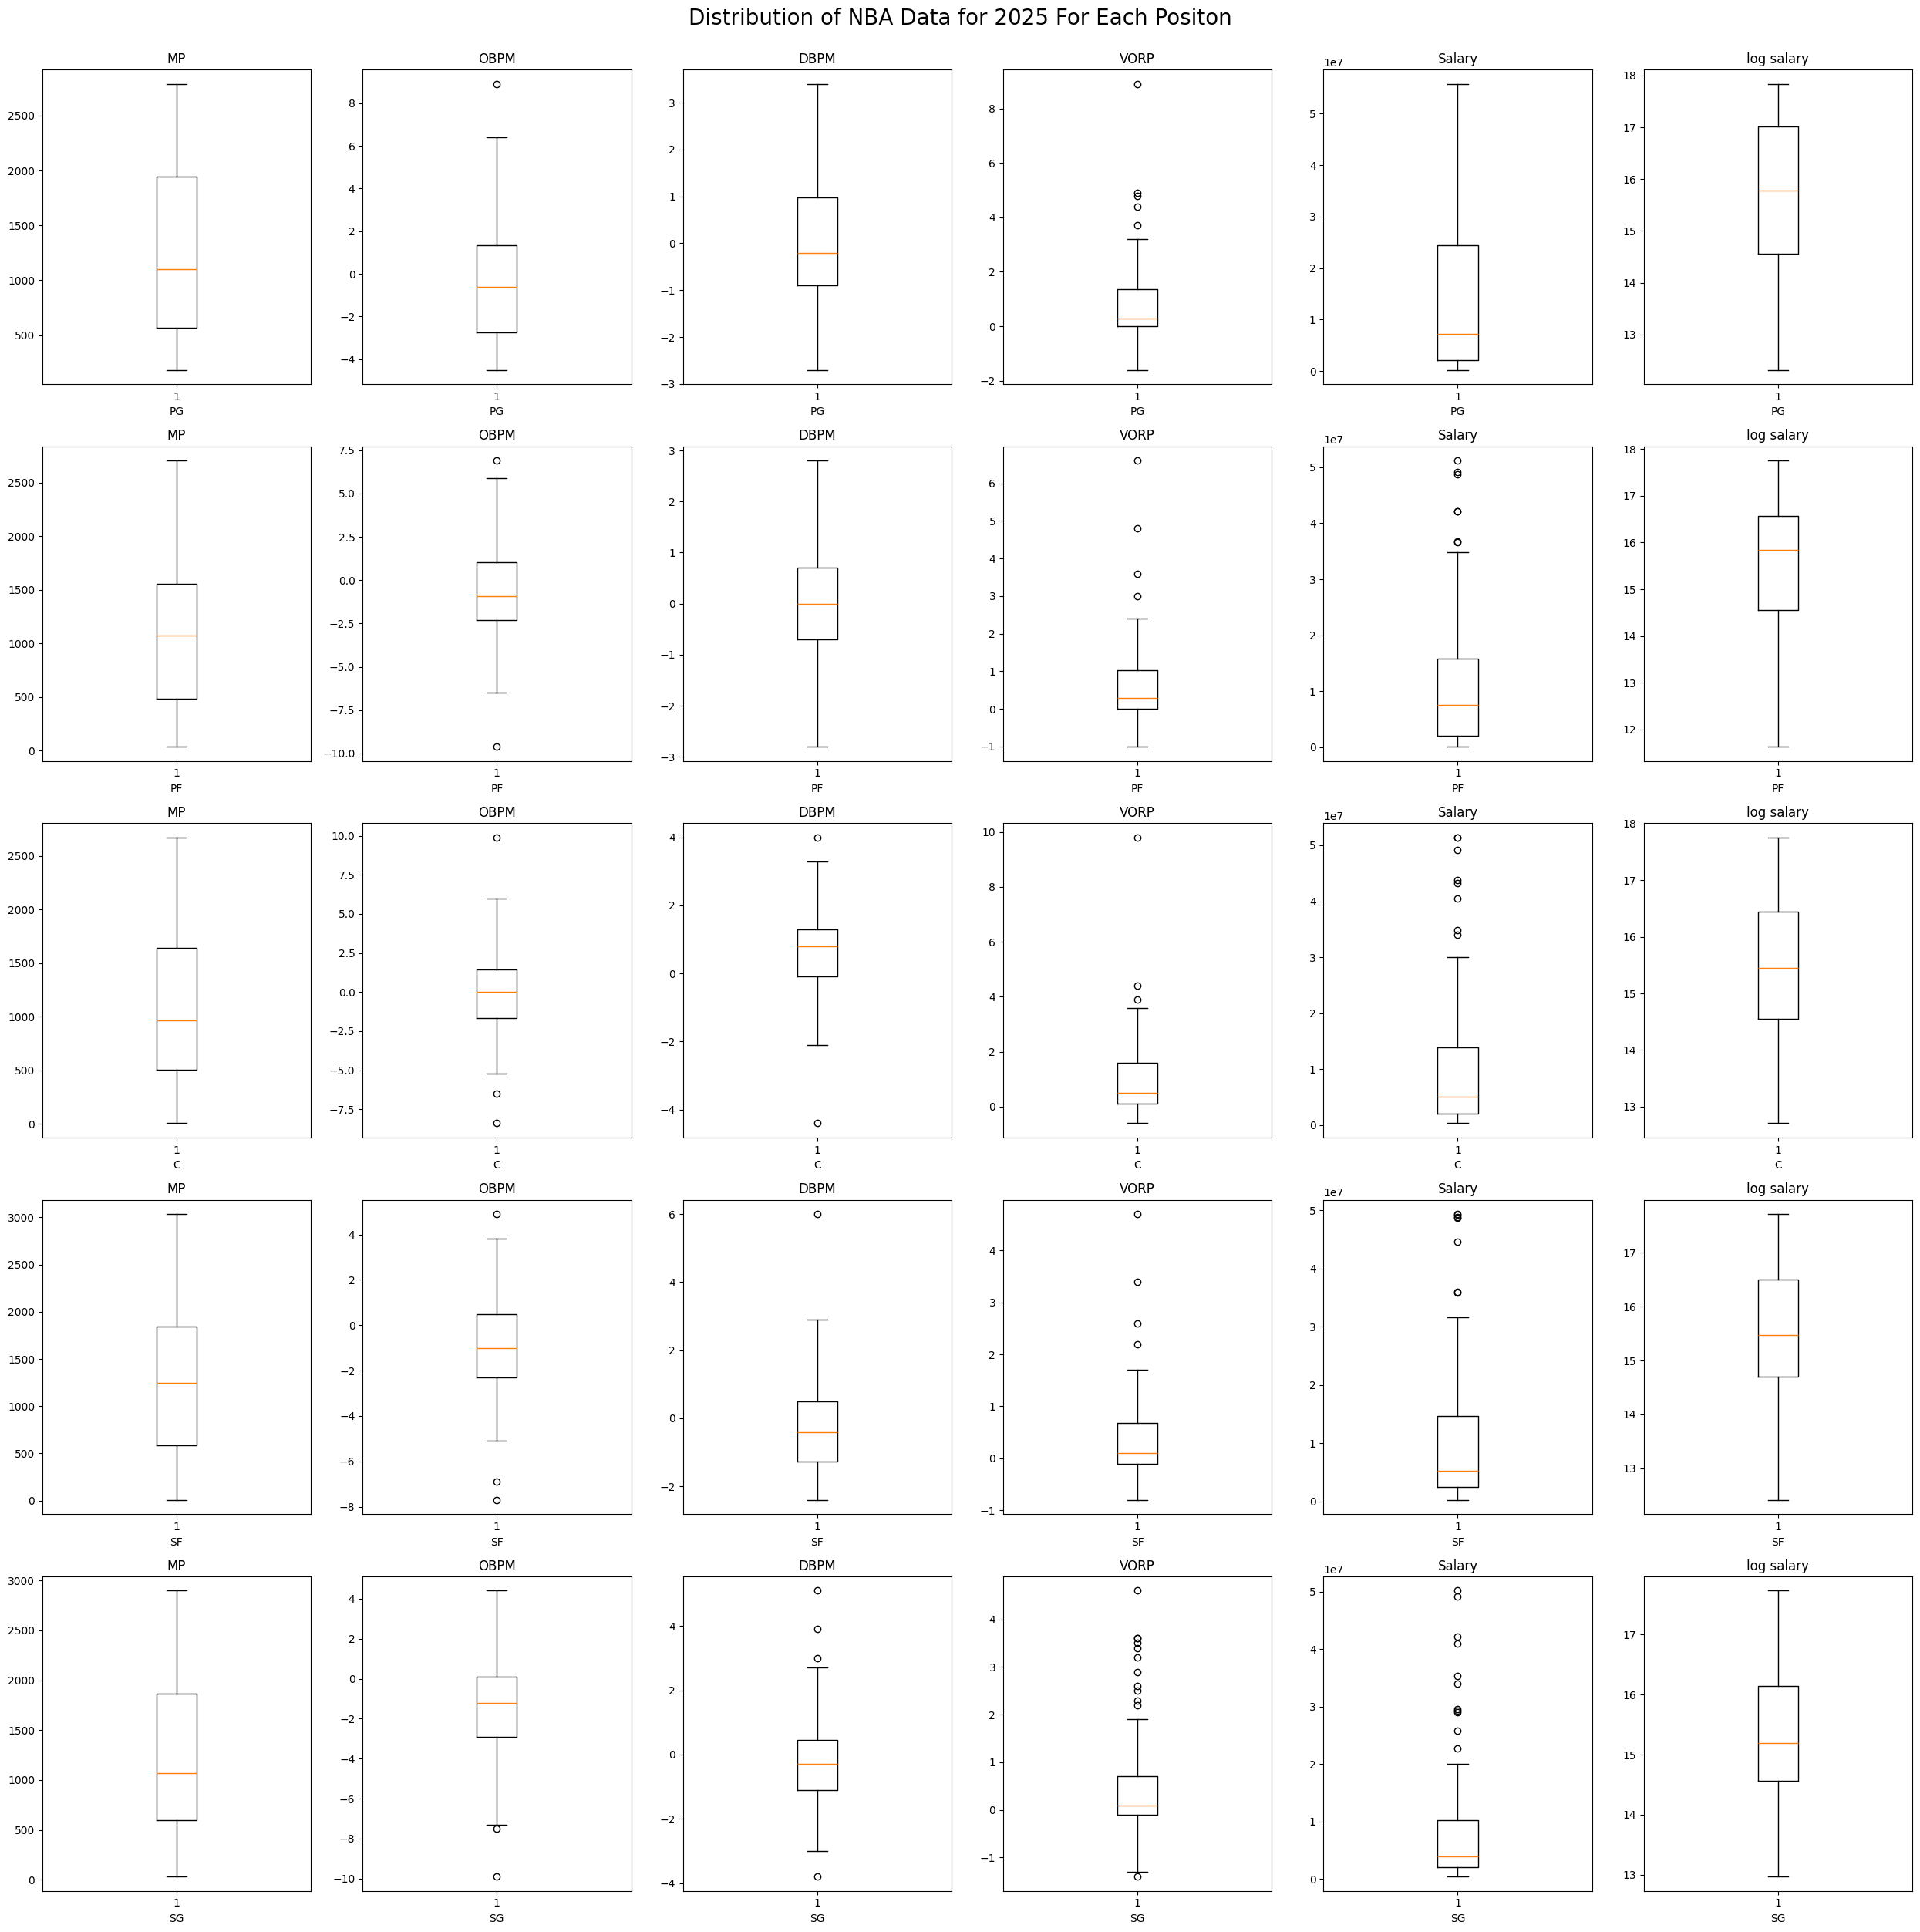

In [351]:
fig, ax = plt.subplots(5, 6, figsize=(25, 25), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "Salary","log salary"]
pos = ["PG", "PF", "C", "SF", "SG"]  

for i, p in enumerate(pos):                 # rows
    dfp = df_2025[df_2025["Pos"] == p]      
    for j, col in enumerate(cols):          # cols
        ax[i, j].boxplot(dfp[col].dropna(), vert=True)
        ax[i, j].set_title(col)
        ax[i, j].set_xlabel(p)

fig.suptitle("Distribution of NBA Data for 2025 For Each Positon", fontsize=20, y=1 )
plt.tight_layout()
plt.show()

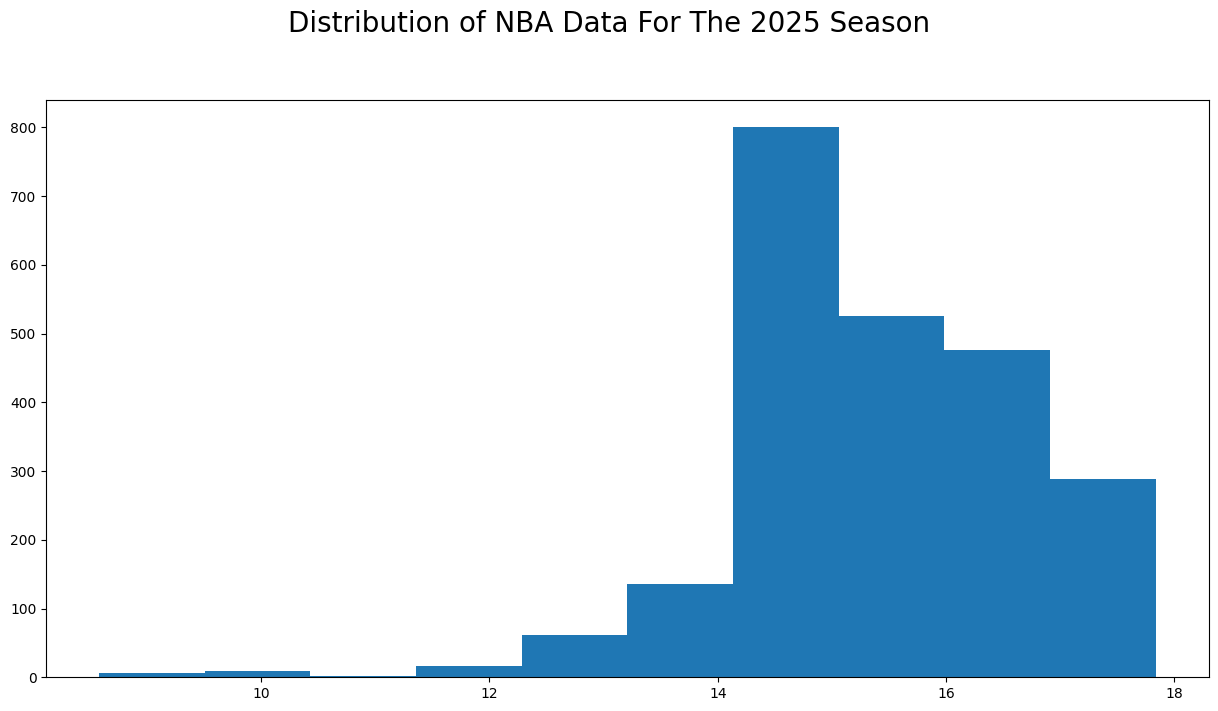

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7.5), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "Salary","log salary"]

ax.hist(df["log salary"])
fig.suptitle("Distribution of Log Salaries", fontsize=20, y=1)
plt.show()

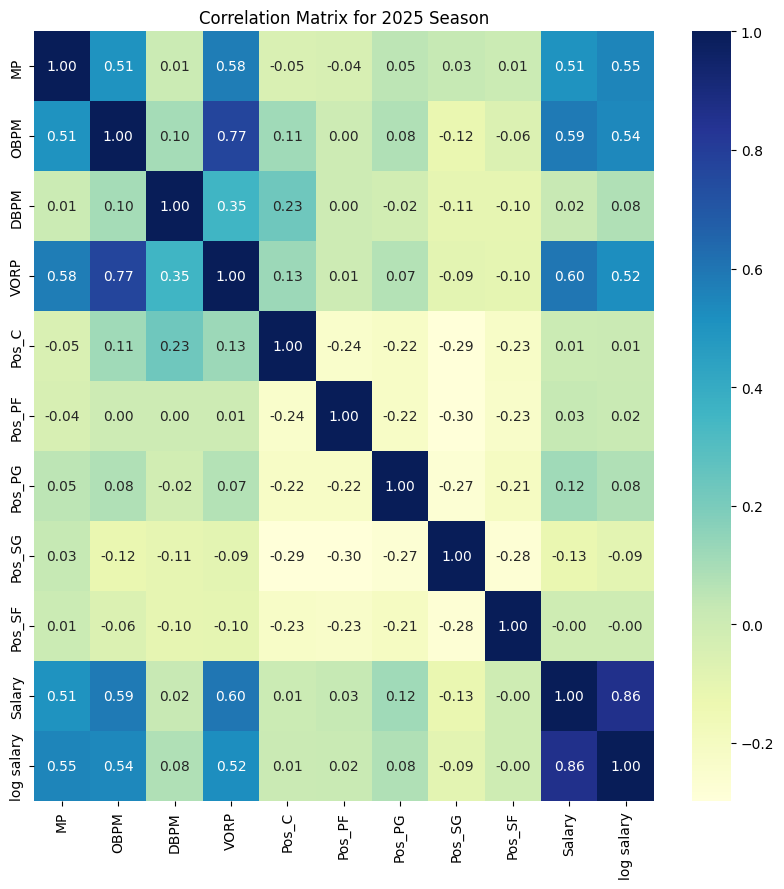

In [352]:
pos_encoded = pd.get_dummies(df_2025['Pos'], prefix='Pos', dtype=int)
df = pd.concat([df_2025, pos_encoded], axis=1)


df_corr = df[["MP", "OBPM", "DBPM", "VORP", "Pos_C", "Pos_PF", "Pos_PG", "Pos_SG", "Pos_SF", "Salary", "log salary"]].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Matrix for 2025 Season") 
plt.tick_params(axis="x", labelrotation=90)

plt.show() 

In [353]:
df_corr["log salary"].sort_values(ascending=False)

log salary    1.000000
Salary        0.858785
MP            0.552239
OBPM          0.542379
VORP          0.518577
DBPM          0.077350
Pos_PG        0.076834
Pos_PF        0.019713
Pos_C         0.013404
Pos_SF       -0.002306
Pos_SG       -0.092651
Name: log salary, dtype: float64

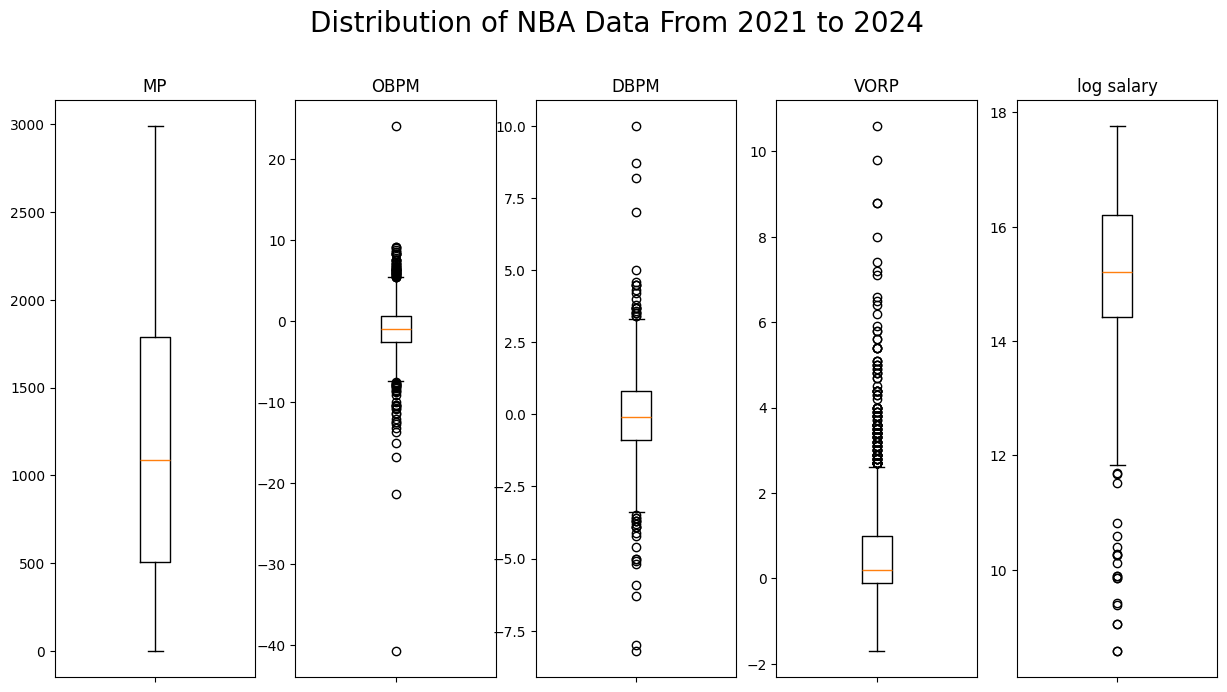

In [354]:
fig, ax = plt.subplots(1, 5, figsize=(15, 7.5), sharey=False)

cols = ["MP", "OBPM", "DBPM", "VORP", "log salary"]

training_df = df_original[df_original["Year"].isin([2020,2021,2022,2023,2024])]

for j, col in enumerate(cols):
    ax[j].boxplot(training_df[col].dropna())
    ax[j].set_title(col)
    ax[j].tick_params(axis="x", labelbottom=False)

fig.suptitle("Distribution of NBA Data From 2021 to 2024", fontsize=20, y=1)
plt.show()


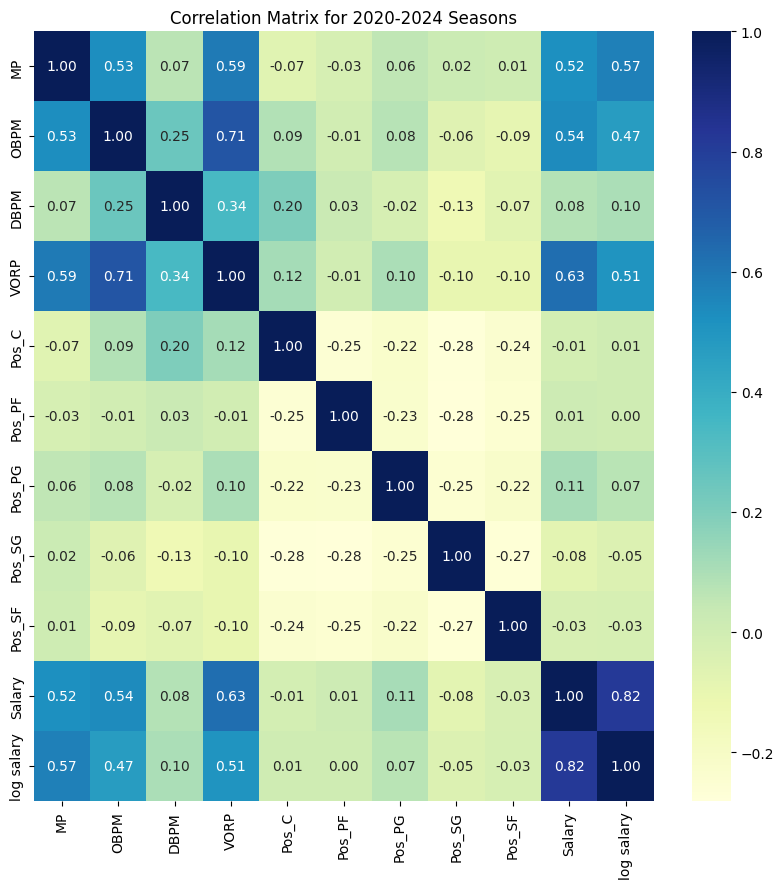

In [355]:
pos_encoded = pd.get_dummies(df_original['Pos'], prefix='Pos', dtype=int)
df = pd.concat([df_original, pos_encoded], axis=1)

df_corr = df[["MP", "OBPM", "DBPM", "VORP", "Pos_C", "Pos_PF", "Pos_PG", "Pos_SG", "Pos_SF", "Salary", "log salary"]].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlation Matrix for 2020-2024 Seasons")
plt.tick_params(axis="x", labelrotation=90)
plt.show() 

In [356]:
df_corr["log salary"].sort_values(ascending=False)

log salary    1.000000
Salary        0.818862
MP            0.573303
VORP          0.507431
OBPM          0.471603
DBPM          0.101795
Pos_PG        0.068656
Pos_C         0.007949
Pos_PF        0.004706
Pos_SF       -0.025842
Pos_SG       -0.048783
Name: log salary, dtype: float64

In [357]:
from sklearn.preprocessing import StandardScaler

features = ["VORP", "OBPM", "MP", "Pos_PG", "DBPM", "Pos_PF", "Pos_C", "Pos_SF", "Pos_SG", "Year"]

df = df.copy()

df_train = df[df["Year"] != 2025].copy()
df_test  = df[df["Year"] == 2025].copy()

X_train = df_train[features].copy()
y_train = df_train["log salary"].copy()

X_test = df_test[features].copy()
y_test = df_test["log salary"].copy()

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=features, index=X_test.index)




In [358]:
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=100, random_state=42)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 1.058
R²: 0.228


In [359]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    # learning dynamics
    "learning_rate": uniform(0.02, 0.15),      # ~[0.02, 0.17]
    "n_estimators":  randint(500, 3000),        # integers

    # tree complexity
    "max_depth":     randint(3, 10),
    "min_child_weight": randint(1, 15),

    # variance control
    "subsample":     uniform(0.7, 0.3),         # [0.7, 1.0]
    "colsample_bytree": uniform(0.7, 0.3),
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=700,          # 700 * 3 = 2100 fits
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_scaled, y_train)

best_model = search.best_estimator_
best_params = search.best_params_
print("Best params:", best_params)
print("Best CV score:", search.best_score_)

Fitting 3 folds for each of 700 candidates, totalling 2100 fits
Best params: {'colsample_bytree': np.float64(0.7717540312647776), 'learning_rate': np.float64(0.04133740530307943), 'max_depth': 3, 'min_child_weight': 12, 'n_estimators': 689, 'subsample': np.float64(0.7796162227564584)}
Best CV score: 0.3403666954063018


In [360]:
new_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    **best_params
)

new_model.fit(X_train_scaled, y_train)
y_pred = new_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


df_test["Predicted Log Salary"] = new_model.predict(df_test[features])
df_test["Residual"] = df_test["log salary"] - df_test["Predicted Log Salary"] 

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 0.956
R²: 0.371


In [361]:
df_test 

,Player,Player-additional,Team,MP,OBPM,DBPM,VORP,Pos,Year,Salary,log salary,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,Predicted Log Salary,Residual
4,Precious Achiuwa,achiupr01,NYK,1170,-2.1,0.2,0.0,C,2025,6000000.0,15.607270,1,0,0,0,0,15.428818,0.178452
9,Steven Adams,adamsst01,HOU,794,0.0,0.3,0.5,C,2025,12600000.0,16.349207,1,0,0,0,0,16.225595,0.123612
14,Bam Adebayo,adebaba01,MIA,2674,1.0,1.0,2.7,C,2025,34848340.0,17.366516,1,0,0,0,0,16.908066,0.458450
17,Ochai Agbaji,agbajoc01,TOR,1739,-0.9,0.2,0.5,SG,2025,4310280.0,15.276513,0,0,0,0,1,16.169678,-0.893164
21,Santi Aldama,aldamsa01,MEM,1660,2.5,0.7,2.2,PF,2025,3960531.0,15.191889,0,1,0,0,0,17.280952,-2.089064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,James Wiseman,wisemja01,IND,5,6.0,-4.4,0.0,C,2025,2237691.0,14.620955,1,0,0,0,0,17.375977,-2.755021
2298,Delon Wright,wrighde01,MIL,405,-4.1,1.6,-0.1,PG,2025,2087519.0,14.551487,0,0,1,0,0,15.852300,-1.300813
2299,Guerschon Yabusele,yabusgu01,PHI,1895,0.1,-1.1,0.5,C,2025,2087519.0,14.551487,1,0,0,0,0,16.443766,-1.892279
2308,Trae Young,youngtr01,ATL,2739,3.3,-2.7,1.7,PG,2025,43031940.0,17.577453,0,0,1,0,0,17.573956,0.003498


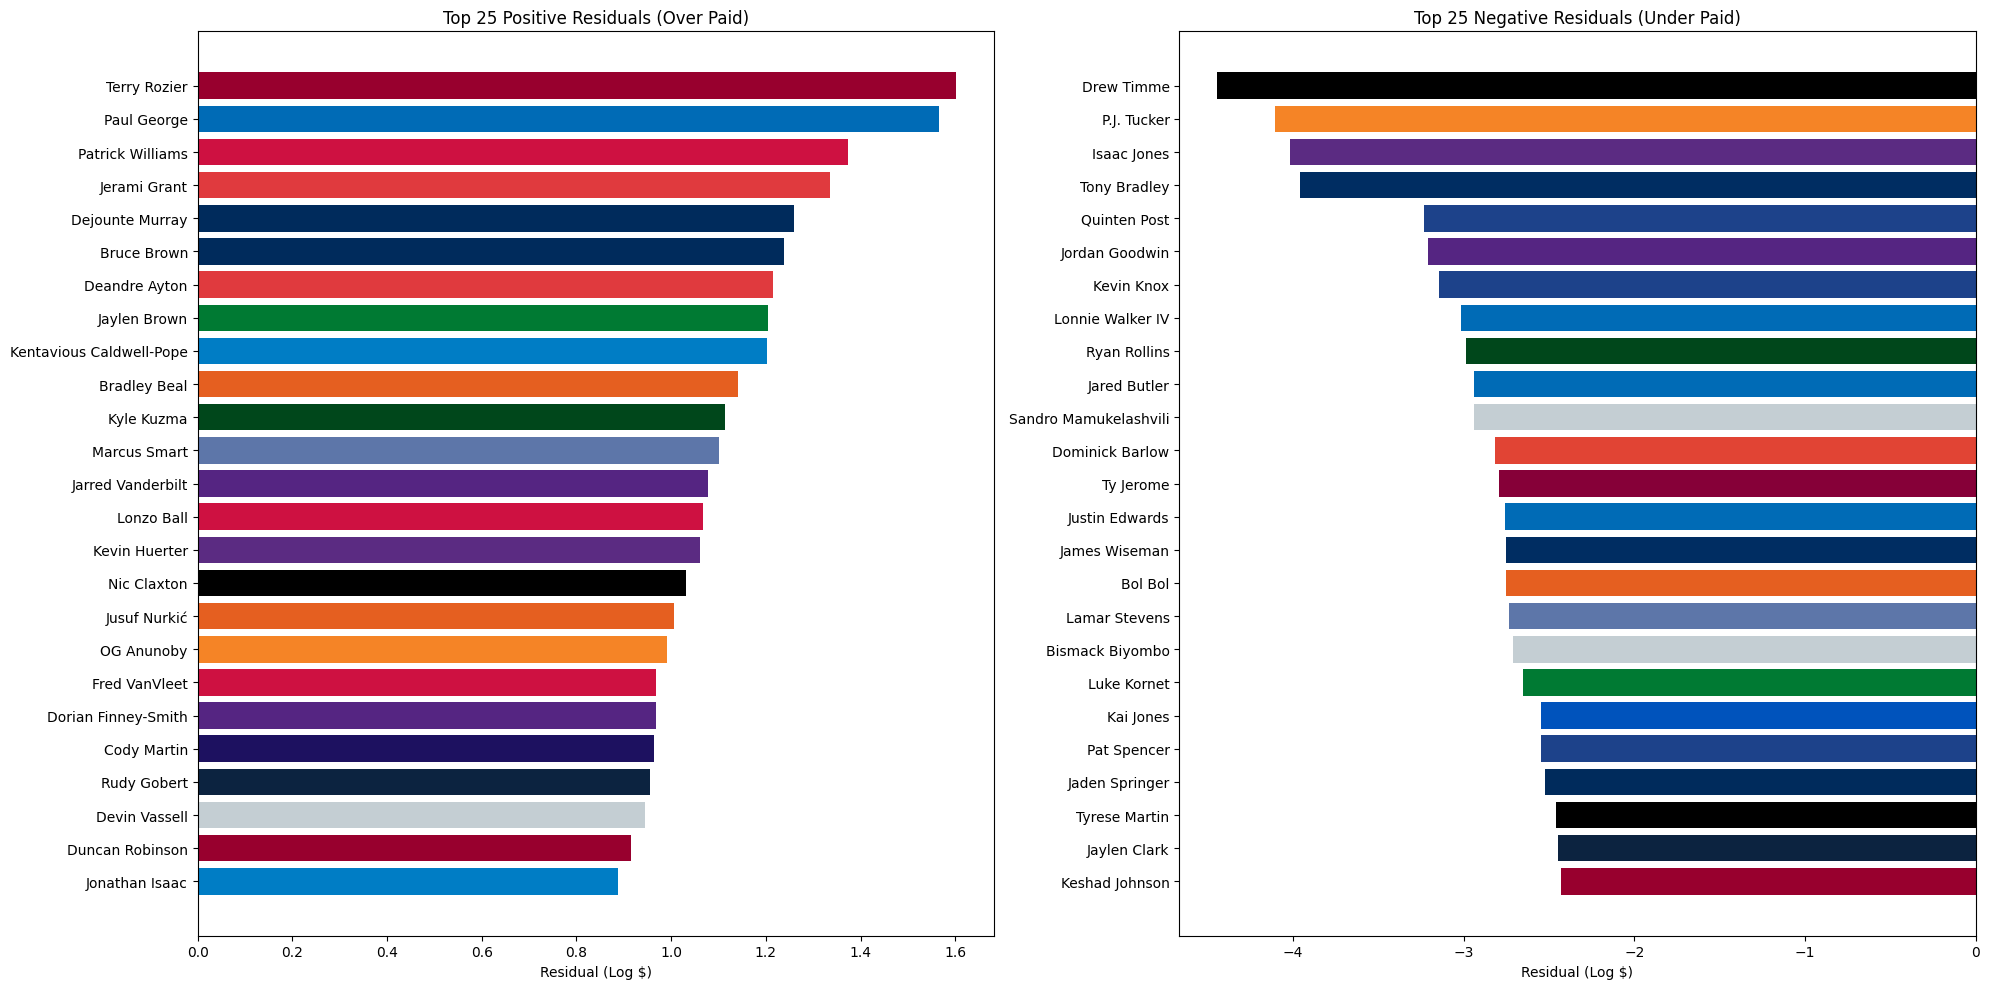

In [362]:


top_25 = df_test.sort_values("Residual", ascending=False).head(25).merge(color_df, on=["Team", ], how="left")
bottom_25 = df_test.sort_values("Residual", ascending=True).head(25).merge(color_df, on=["Team", ], how="left") 

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=False)

# Overpaid (actual - predicted > 0)
ax[0].barh(top_25["Player"], top_25["Residual"], color=top_25["hex"])
ax[0].set_title("Top 25 Positive Residuals (Over Paid)")
ax[0].set_xlabel("Residual (Log $)")
ax[0].invert_yaxis()

# Underpaid (actual - predicted < 0)
ax[1].barh(bottom_25["Player"], bottom_25["Residual"], color=bottom_25["hex"])
ax[1].set_title("Top 25 Negative Residuals (Under Paid)")
ax[1].set_xlabel("Residual (Log $)")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

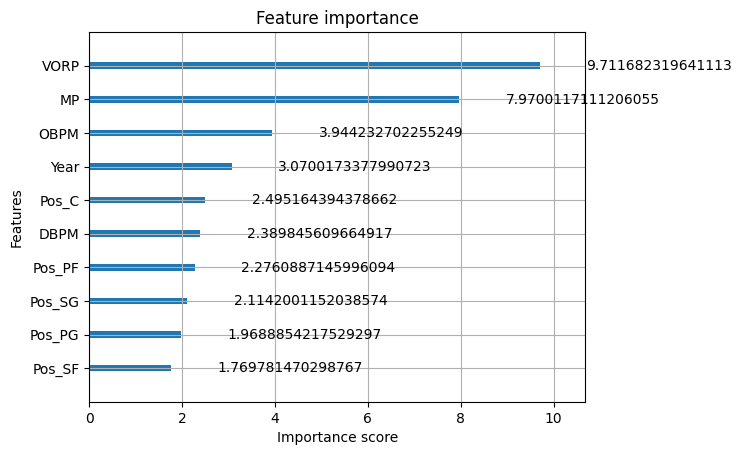

In [363]:
xgb.plot_importance(new_model, importance_type="gain")


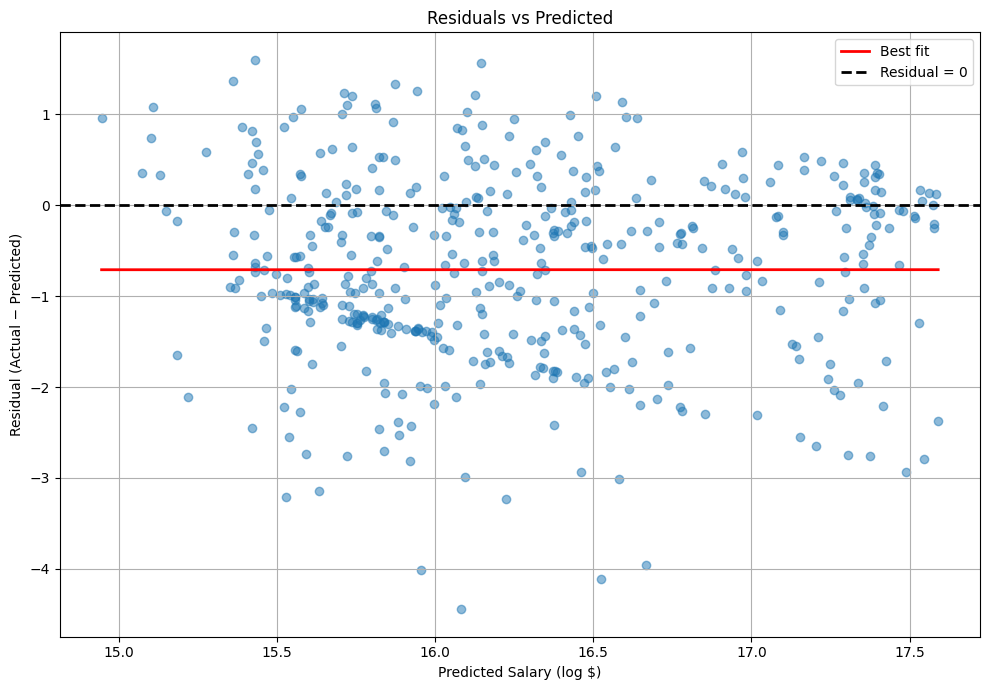

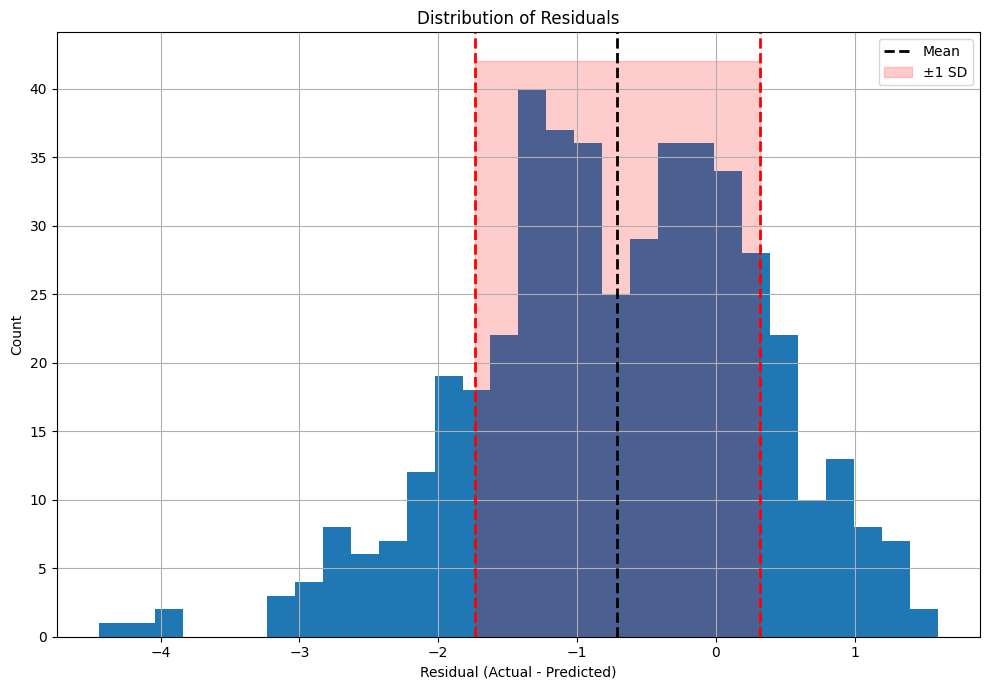

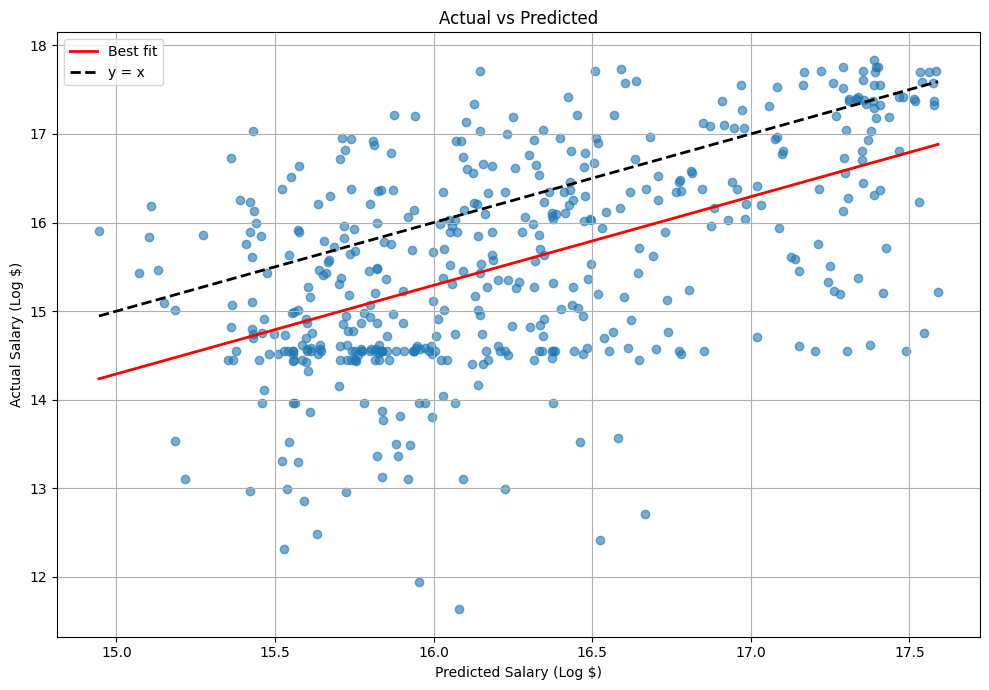

In [393]:
import numpy as np
import matplotlib.pyplot as plt

data = df_test.copy()

# =========================
# FIG 1: Residuals vs Predicted
# =========================
x = data["Predicted Log Salary"].to_numpy()
y = data["Residual"].to_numpy()

mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]

m, b = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 200)

fig1, ax1 = plt.subplots(figsize=(10, 7))
ax1.scatter(x, y, alpha=0.5)
ax1.plot(xx, m*xx + b, linewidth=2, color="red", label="Best fit")
ax1.axhline(0, linestyle="--", color="black", linewidth=2, label="Residual = 0")
ax1.set_xlabel("Predicted Salary (log $)")
ax1.set_ylabel("Residual (Actual − Predicted)")
ax1.set_title("Residuals vs Predicted")
ax1.grid(True)
ax1.legend()
plt.tight_layout()
plt.show()


# =========================
# FIG 2: Distribution of Residuals
# =========================
res = data["Residual"].to_numpy()
res = res[np.isfinite(res)]

mu = np.mean(res)
sd = np.std(res, ddof=1)

fig2, ax2 = plt.subplots(figsize=(10, 7))
ax2.hist(res, bins=30)
ax2.axvline(mu, linestyle="--", color="black", linewidth=2, label="Mean")
ax2.axvline(mu - sd, linestyle="--", color="red", linewidth=2)
ax2.axvline(mu + sd, linestyle="--", color="red", linewidth=2)

ymax = ax2.get_ylim()[1]
ax2.fill_between([mu - sd, mu + sd], 0, ymax, alpha=0.2, color="red", label="±1 SD")

ax2.set_ylabel("Count")
ax2.set_xlabel("Residual (Actual - Predicted)")
ax2.set_title("Distribution of Residuals")
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()


# =========================
# FIG 3: Actual vs Predicted
# =========================
x = data["Predicted Log Salary"].to_numpy()   # predicted
y = data["log salary"].to_numpy()             # actual

mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]

m, b = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 200)

fig3, ax3 = plt.subplots(figsize=(10, 7))
ax3.scatter(x, y, alpha=0.6)
ax3.plot(xx, m*xx + b, linewidth=2, color="red", label="Best fit")
ax3.plot(xx, xx, linestyle="--", linewidth=2, color="black", label="y = x")

ax3.set_xlabel("Predicted Salary (Log $)")
ax3.set_ylabel("Actual Salary (Log $)")
ax3.set_title("Actual vs Predicted")
ax3.grid(True)
ax3.legend()
plt.tight_layout()
plt.show()


,Player,Player-additional,Team,MP,OBPM,DBPM,VORP,Pos,Year,Salary,log salary,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG,Predicted Log Salary,Residual
487,Stephen Curry,curryst01,GSW,2252,6.4,0.0,4.8,PG,2025,55761216.0,17.836589,0,0,1,0,0,17.38983,0.446759


method

<Figure size 1000x600 with 0 Axes>

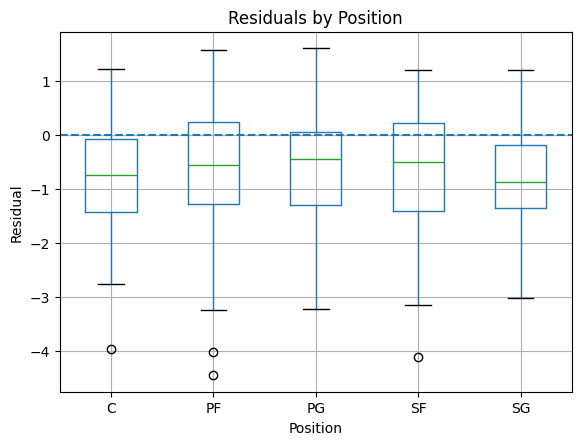

In [365]:
plt.figure(figsize=(10,6))
df_test.boxplot(column="Residual", by="Pos")
plt.axhline(0, linestyle="--")
plt.title("Residuals by Position")
plt.suptitle("")
plt.xlabel("Position")
plt.ylabel("Residual")
plt.show()

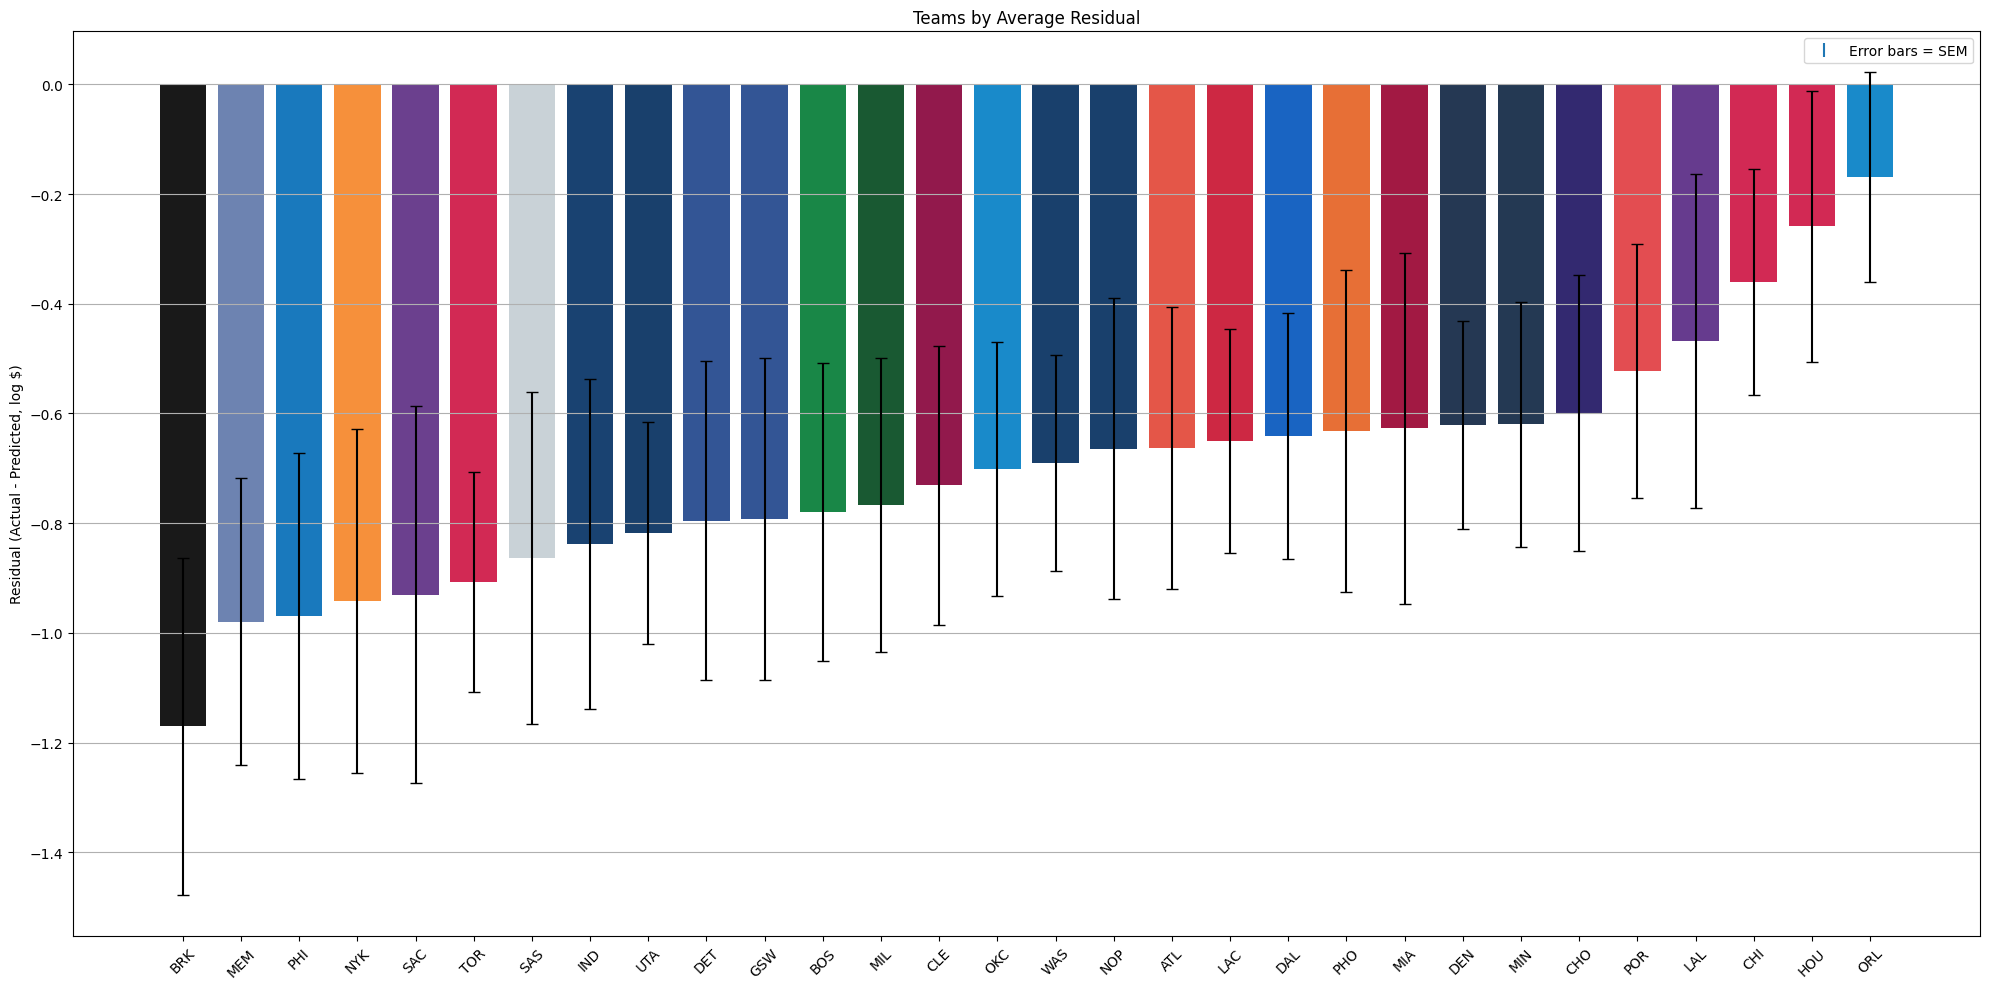

In [366]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), sharey=True)

team_stats = (
    df_test.groupby("Team")["Residual"]
    .agg(mean="mean", std="std", n="count")
    .reset_index()
)
team_stats["sem"] = team_stats["std"] / np.sqrt(team_stats["n"])

data = (
    team_stats.sort_values("mean", ascending=True).merge(color_df, on="Team", how="left")
)

ax.bar(
    x=data["Team"],
    height=data["mean"],
    color=data["hex"],
    yerr=data["sem"],   # or: data["std"]
    capsize=4,
    
    alpha=0.9
)

ax.set_title("Teams by Average Residual")
ax.set_ylabel("Residual (Actual - Predicted, log $)")
ax.grid(True, axis="y")
ax.tick_params(axis="x", rotation=45)
ax.errorbar([], [], yerr=[1], fmt="none", capsize=10, label="Error bars = SEM")
ax.legend()
plt.tight_layout()
plt.show()